# Recovering images with a variational network

The goal of this homework is to implement a variational network that recovers images from few measurements. Training a variational network is time intensive, therefore we work with a toy class of images only, namely handwritten digits. Those images are very small and save us computational time relative to working with real-world images arising in practical applications.

Most of the implementation is set up already, your task is to implement the variational network and run the code.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader

### We start with downloading the MNIST digits

In [2]:
transform= torchvision.transforms.ToTensor()
dataset = torchvision.datasets.MNIST('./MNIST', True, transform=transform,download=True)

### We consider reconstruction from 4x undersampled random measurements

In [3]:
# Measurement Matrix
n=dataset[0][0].shape[1] #28
m=n//4   # 4 times acceleration

# The matrix A is Gaussian, mean 0, variance 1
torch.manual_seed(0)
A=torch.normal(0, 1, size=(m, n)) 

device='cpu'
A=A.to(device)

In [4]:
##Prepare data
class data():
        
    def __len__(self):
        return len(dataset)
    
    def __getitem__(self, idx):
        
        data=dict()
        data['x']=dataset[idx][0].to(device)
        data['y']=(A@data['x'][0]).unsqueeze(0).to(device) #y=Ax

        return data

In [5]:
Data=data()

#Split in train, validate and test sets
train_set, val_set, test_set = torch.utils.data.random_split(Data,[5000,1000,54000])

#Dataloader
train_dl = DataLoader(train_set, batch_size=1)
val_dl = DataLoader(val_set, batch_size=1)
test_dl= DataLoader(test_set, batch_size=1,shuffle=True)

### Variational network

The task is to implement a variational network in the cell below. The network consists of num_cascades = 8 cascades. The network should output the initialization, as well as the reconstruction after every cascade (see last cell).

The network is initialized as 
$$
x^t = A^T y,
$$
and implements the iterations
$$
x^{t+1} = x^t - \eta (A^T(Ax^t -y) + R_t(x^t)),
$$
where $R_t$ is a regularizer parameterized as
$$
R_t(x) = \sum_{i=1}^k C_{t,1,i}^T relu(C_{t,2,i} x).
$$
Here, $C_{t,j,i}$ is a convolution with a kernel of size $3\times 3$. Note that the regularizer is a simple convolutional network that can be implemented with the functions nn.Conv2d() and nn.ReLU(). The parameter $\eta$ is a trainable parameter, initialize it to $\eta=0.01$.

In [6]:
#Whole Variational Network    
class VarNet(nn.Module):
    def __init__(self, num_cascades=8):
        super(VarNet, self).__init__()
        self.num_cascades = num_cascades
        self.matrix = A
        self.step_size = torch.nn.Parameter(torch.tensor([0.01]))
        # self.step_size = 0.01
        self.k = 48
        self.cnn_regularizer = nn.Sequential(
            nn.Conv2d(1, self.k, (3, 3), padding=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(self.k, 1, (3, 3), padding=(1, 1))
        )
        self.cascades = nn.ModuleList(
            [self.cnn_regularizer for _ in range(self.num_cascades)]
        )
        
    def forward(self, y):
        x_init = A.T @ y
        x_current = x_init.clone()
        x_int = []
        x_int.append(x_current)
        for cascade in self.cascades:
            x_next = x_current - self.step_size * (A.T @ (A @ x_current - y) + cascade(x_current.unsqueeze(0)).squeeze(0))
            x_int.append(x_next)
            x_current = x_next
        return x_int 

In [7]:
model=VarNet()
model=model.to(device)

### Below are funtions to train and test the network

In [8]:
##Loss
def mse(gt: torch.Tensor, pred:torch.Tensor)-> torch.Tensor:
    loss = torch.nn.MSELoss()
    return loss(gt,pred)

#train function
def train(model, optimizer, sample):
    model.train()
    
    # reset optimizer's gradient
    optimizer.zero_grad()

    # define variables
    y = sample['y'].squeeze(0)
    x = sample['x'].squeeze(0)
      
    # get the prediction
    pred = model(y)[-1]
    pred_loss = mse(pred, x)
    
    #one step of training
    pred_loss.backward()
    optimizer.step()

    return pred_loss.item()

#test function
def test(model, sample): 
    model.eval()
    
    with torch.no_grad(): 
        
        y = sample['y'].squeeze(0)
        x = sample['x'].squeeze(0) 
        
        # get the prediction
        pred = model(y)[-1]
        pred_loss = mse(pred, x)

    return pred_loss.item()

#reconstruction
def inference(model, sample): 
    model.eval()
    
    with torch.no_grad(): 
        
        y = sample['y'].squeeze(0)
        pred=model(y)

    return pred

### Training

As optimizer, we choose the Adam optimizer (a standard adaptive gradient method). We then train the model for 10 epochs; training for more epochs gives better results, but after 10 epochs we already get a model that works reasonably well for image recovery.

In [9]:
optimizer = optim.Adam(model.parameters(), lr=0.0007, weight_decay=0)

max_epoch = 10
mse_train=[]
mse_test= []

for epoch in tqdm(range(max_epoch)):
    # Initialize Loss and Accuracy
    train_loss = val_loss= 0.0
    
    ### Training Phase
    
    ## Iterate over the train_dataloader
    with tqdm(total=len(train_dl)) as pbar:
        for sample in train_dl:            
            curr_loss = train(model, optimizer, sample)
            train_loss += curr_loss / len(train_dl) 
            pbar.update(1)
    
    mse_train.append(train_loss)


    ### Validation Phase 
    
    ## Iterate over the validation_dataloader
    with tqdm(total=len(val_dl)) as pbar:
        for sample in val_dl: 
            curr_loss= test(model, sample)
            val_loss += curr_loss / len(val_dl)
            pbar.update(1)
    
    mse_test.append(val_loss) 
    
    print(epoch, train_loss, val_loss)    


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0 0.033739103394932954 0.030479454739019255


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

1 0.02866248979382209 0.027446120826061824


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

2 0.026604347950220007 0.026130315539427112


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

3 0.025582028068089825 0.02530023975623774


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

4 0.02490303499004798 0.024686104403808667


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

5 0.024381550681451362 0.024218321490101575


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

6 0.023950233087409276 0.02384449875284916


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

7 0.023569054028158985 0.023402207179227842


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

8 0.023215631851693647 0.02308919489569963


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

9 0.022899221152346595 0.02279897149512543


Text(0, 0.5, 'MSE')

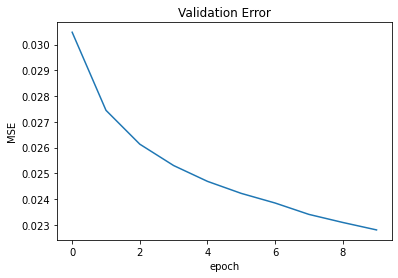

In [10]:
plt.plot(mse_test)
plt.title('Validation Error')
plt.xlabel('epoch')
plt.ylabel('MSE')

### Visualization how VarNet reconstructs an image

Text(0.5, 1.0, 'Ground Truth')

<Figure size 432x288 with 0 Axes>

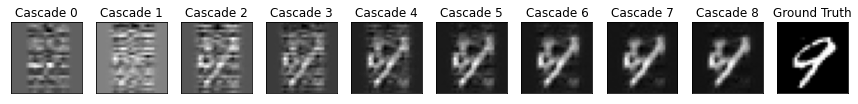

In [11]:
sample=next(iter(test_dl))  #random sample from test set
pred=inference(model,sample) #reconstruct random sample

plt.gray()
fig, ax = plt.subplots(1, 10,figsize=(15, 15))
for i in range(9):
    ax[i].imshow(pred[i].squeeze(0).detach().cpu().numpy())
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_title('Cascade '+ str(i))
    
ax[9].imshow(sample['x'].squeeze(0).squeeze(0).cpu().numpy())   
ax[9].set_xticks([])
ax[9].set_yticks([])
ax[9].set_title('Ground Truth')  